In [1]:
# Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
# Loading Amazon UK product dataset
df = pd.read_csv("/Users/adimalik/Documents/Iron Hack/Labs/Week5/2. lab-eda-bivariate/amz_uk_price_prediction_dataset.csv")

In [4]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [66]:
## "#?" defines the questions asked in the lab.

In [5]:
### Part 1: Analyzing Best-Seller Trends Across Product Categories ###

In [59]:
#? 1. Objective: Understand the relationship between product categories and their best-seller status.

#? Crosstab Analysis:

#? Create a crosstab between the product `category` and the `isBestSeller` status.

In [7]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [60]:
#? Are there categories where being a best-seller is more prevalent? 

#? * Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [9]:
crosstab.columns

Index([False, True], dtype='bool', name='isBestSeller')

In [10]:
# Calculate the proportion of best-sellers for each category

crosstab['isBestSeller'] = crosstab[True] / (crosstab[True] + crosstab[False])

In [11]:
# Sort the categories based on the proportion of best-sellers in descending order

sorted_categories = crosstab.sort_values(by='isBestSeller', ascending=False)

In [12]:
print(sorted_categories[[False, True, 'isBestSeller']])

isBestSeller                      False  True  isBestSeller
category                                                   
Grocery                            9008   556      0.058135
Smart Home Security & Lighting       98     6      0.057692
Health & Personal Care             9017   552      0.057686
Mobile Phone Accessories            248    11      0.042471
Power & Hand Tools                 8353   306      0.035339
...                                 ...   ...           ...
CD, Disc & Tape Players            8798     0      0.000000
General Music-Making Accessories    259     0      0.000000
Snowboard Boots                    1449     0      0.000000
Boxes & Organisers                  911     0      0.000000
eBook Readers & Accessories         246     0      0.000000

[296 rows x 3 columns]


In [62]:
#? 2. Statistical Tests:

#? Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

In [14]:
# Chi-square tests

from scipy.stats import chi2_contingency

# Chi-square test for 'category' and 'isBestSeller'

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab)

chi2_statistic, chi2_p_value

(36684.23786636857, 0.0)

In [63]:
#? Compute Cramér's V to understand the strength of association between best-seller status and category.

In [17]:
crosstab.drop(columns = "isBestSeller", inplace = True)

In [18]:
# Cramér's V

from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab' using the "cramer" method

association(crosstab, method="cramer")

0.1222829439760564

In [64]:
#? 3. **Visualizations**:

#? Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

<Axes: xlabel='category'>

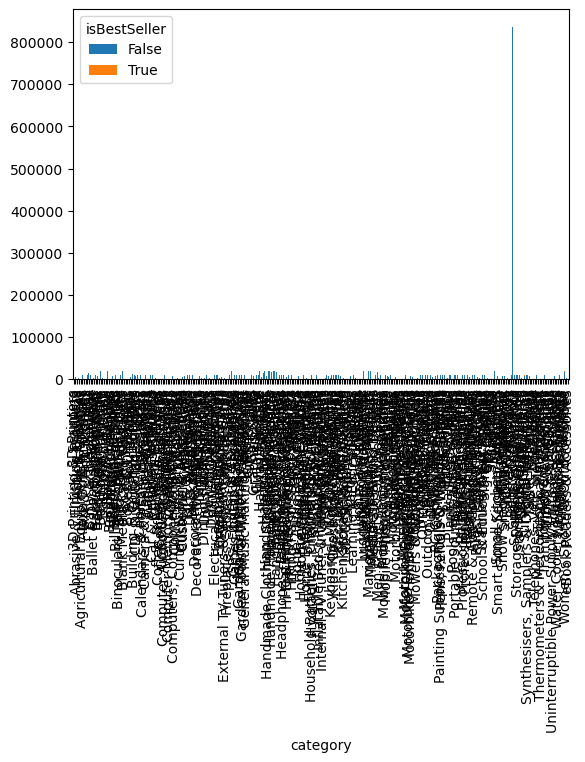

In [19]:
crosstab.plot(kind="bar", stacked=True)

In [28]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data > lower_bound) & (data < upper_bound)]
    
    return outliers

In [29]:
tukeys_test_outliers(crosstab[False])

category
3D Printers                         247
3D Printing & Scanning             4065
Abrasive & Finishing Products       245
Action Cameras                     1696
Adapters                            251
                                  ...  
Wind Instruments                    243
Window Treatments                   234
Women                             17559
Women's Sports & Outdoor Shoes     1939
eBook Readers & Accessories         246
Name: False, Length: 295, dtype: int64

<Axes: xlabel='category'>

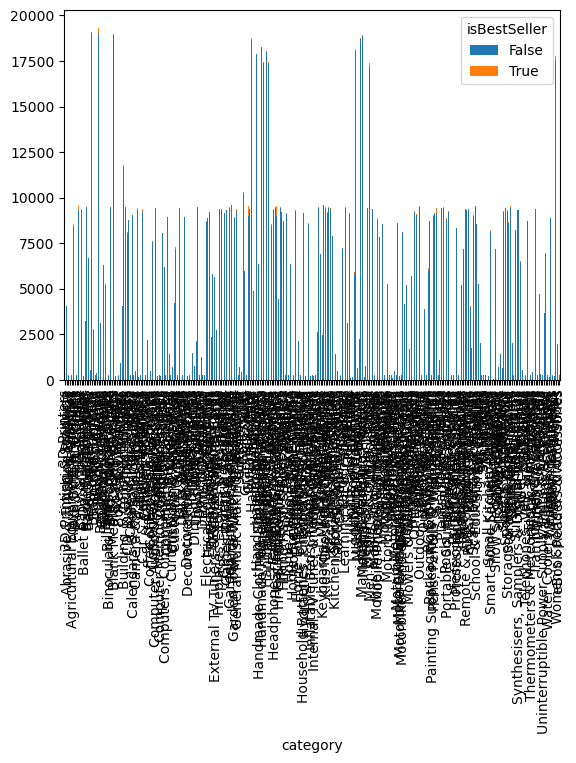

In [33]:
crosstab[crosstab.index != "Sports & Outdoors"].plot(kind="bar", stacked=True)

In [34]:
### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [65]:
#? **Objective**: Investigate how different product categories influence product prices.

#? 0. **Preliminary Step: Remove outliers in product prices.**

#? For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

#? *Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [36]:
# Calculate the first quartile (Q1) and third quartile (Q3)

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

In [37]:
# Calculate the interquartile range (IQR)

IQR = Q3 - Q1

In [38]:
# Define the lower and upper bounds to identify outliers

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [39]:
# Filter out the outliers

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

In [67]:
#? 1. **Violin Plots**:
    
#? Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.

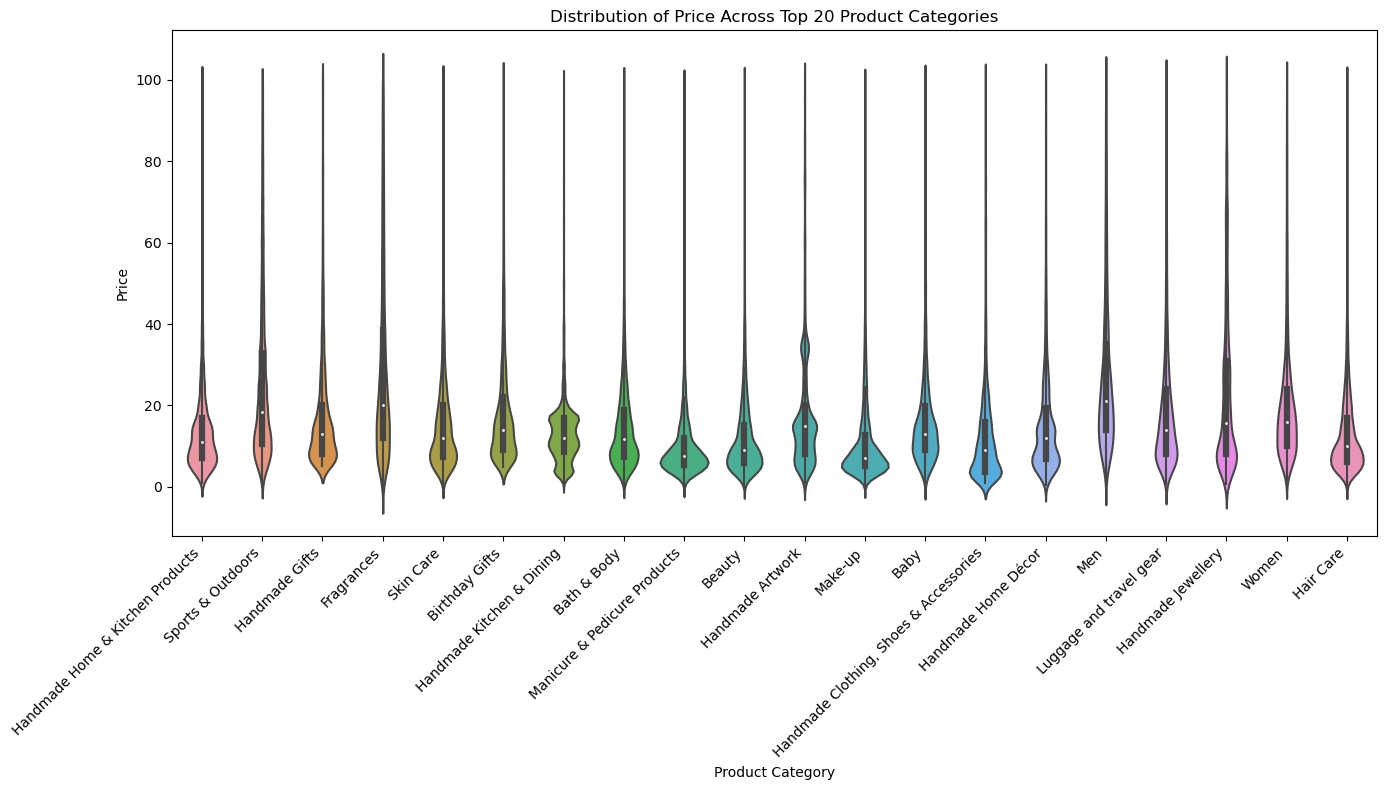

In [41]:
# Filter out the top 20 categories based on count
top_categories = df_filtered['category'].value_counts().nlargest(20).index

df_filtered_top20 = df_filtered[df_filtered['category'].isin(top_categories)]

# Create the violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='category', y='price', data=df_filtered_top20)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Product Category')
plt.ylabel('Price')
plt.title('Distribution of Price Across Top 20 Product Categories')
plt.tight_layout()
plt.show()

In [68]:
#? Which product category tends to have the highest median price? Don't filter here by top categories.

In [44]:
# Calculate the median price for each category

median_prices_by_category = df_filtered.groupby('category')['price'].median()

In [45]:
# Find the category with the highest median price

highest_median_price_category = median_prices_by_category.idxmax()
highest_median_price = median_prices_by_category.max()

In [46]:
print(f"The category with the highest median price is '{highest_median_price_category}' with a median price of {highest_median_price:.2f}")

The category with the highest median price is 'Desktop PCs' with a median price of 74.00


In [70]:
#? 2. **Bar Charts**:

#? Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

In [52]:
# Filter out the top 10 categories based on count

top_categories_10 = df_filtered['category'].value_counts().nlargest(10).index
df_filtered_top10 = df_filtered[df_filtered['category'].isin(top_categories_10)]

In [53]:
# Calculate the average price for each category

average_prices_by_category = df_filtered_top10.groupby('category')['price'].mean()

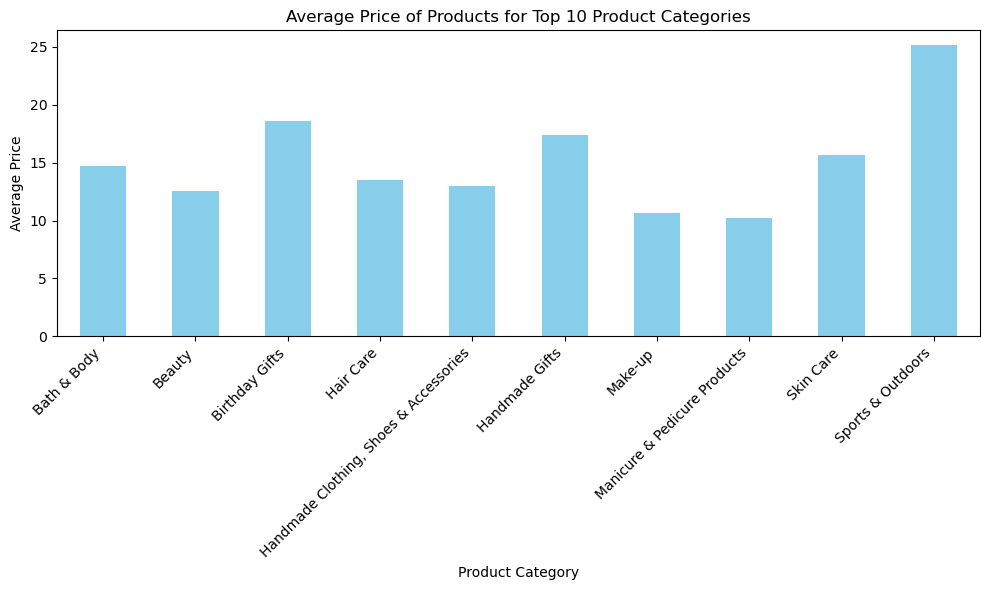

In [54]:
# Create the bar chart

plt.figure(figsize=(10, 6))
average_prices_by_category.plot(kind='bar', color='skyblue')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.title('Average Price of Products for Top 10 Product Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [71]:
#? Which product category commands the highest average price? Don't filter here by top categories.

In [56]:
# Calculate the average price for each category

average_prices_by_category = df_filtered.groupby('category')['price'].mean()

In [57]:
# Find the category with the highest average price

highest_average_price_category = average_prices_by_category.idxmax()
highest_average_price = average_prices_by_category.max()

In [58]:
print(f"The category with the highest average price is '{highest_average_price_category}' with an average price of {highest_average_price:.2f}")

The category with the highest average price is 'Motherboards' with an average price of 68.77


In [72]:
#? 3. **Box Plots**:

#? Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

In [73]:
# Filter out the top 10 categories based on count

top_categories_10 = df_filtered['category'].value_counts().nlargest(10).index
df_filtered_top10 = df_filtered[df_filtered['category'].isin(top_categories_10)]

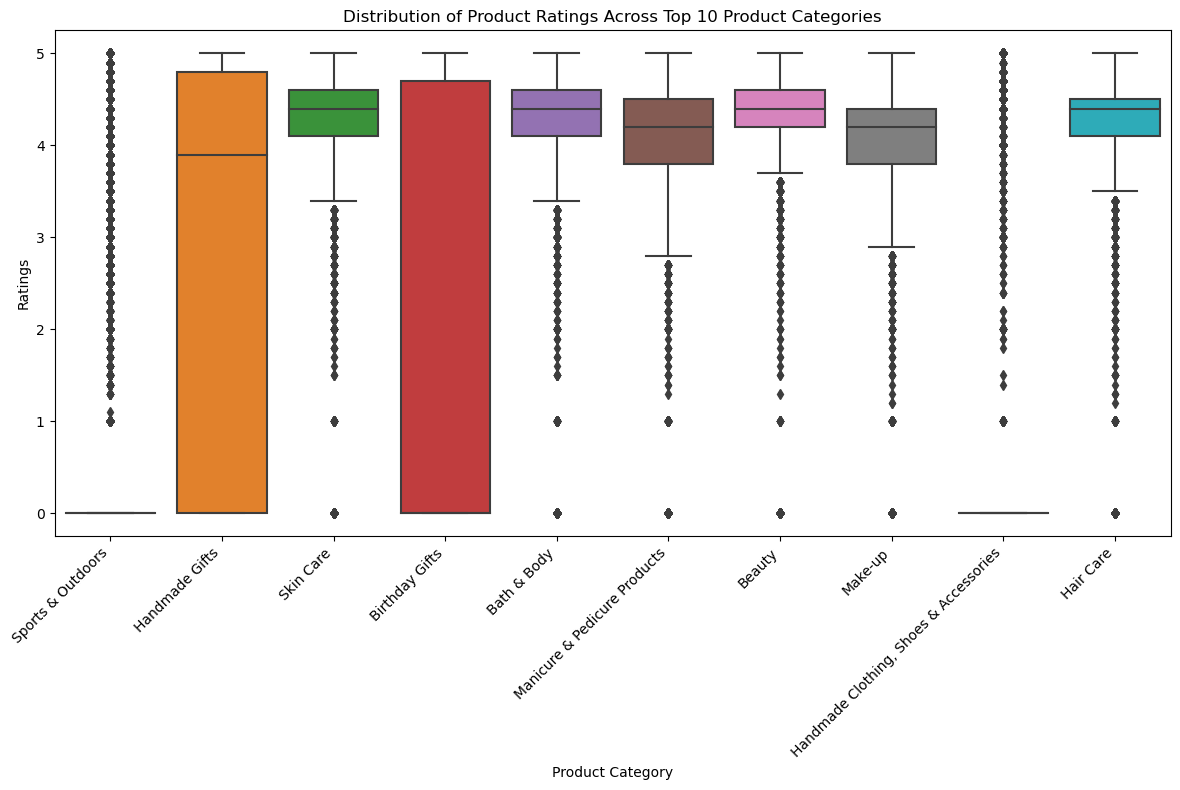

In [74]:
# Create the box plot

plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='stars', data=df_filtered_top10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Product Category')
plt.ylabel('Ratings')
plt.title('Distribution of Product Ratings Across Top 10 Product Categories')
plt.tight_layout()
plt.show()

In [80]:
#? Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [77]:
# Calculate the median rating for each category

median_ratings_by_category = df_filtered.groupby('category')['stars'].median()

In [78]:
# Find the category with the highest median rating

highest_median_rating_category = median_ratings_by_category.idxmax()
highest_median_rating = median_ratings_by_category.max()

In [79]:
print(f"The category with the highest median rating is '{highest_median_rating_category}' with a median rating of {highest_median_rating:.2f}")

The category with the highest median rating is 'Computer Memory' with a median rating of 4.70


In [81]:
### Part 3: Investigating the Interplay Between Product Prices and Ratings 

In [82]:
#? **Objective**: Analyze how product ratings (`stars`) correlate with product prices.

#? 1. **Correlation Coefficients**:

#? Calculate the correlation coefficient between `price` and `stars`.

In [113]:
# Calculate the correlation coefficient

correlation_coefficient = df_filtered['price'].corr(df_filtered['stars'])

In [84]:
print(f"The correlation coefficient between price and stars is: {correlation_coefficient:.2f}")

The correlation coefficient between price and stars is: -0.08


In [86]:
#? Is there a significant correlation between product price and its rating?

In [91]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df_filtered['price'], df_filtered['stars'])

print(f"Correlation coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.5f}")

Correlation coefficient: -0.08
P-value: 0.00000


In [89]:
# Check if the correlation is statistically significant
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between product price and its rating.")
else:
    print("There is no significant correlation between product price and its rating.")

There is a significant correlation between product price and its rating.


In [92]:
#? 2. **Visualizations**:

#? Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

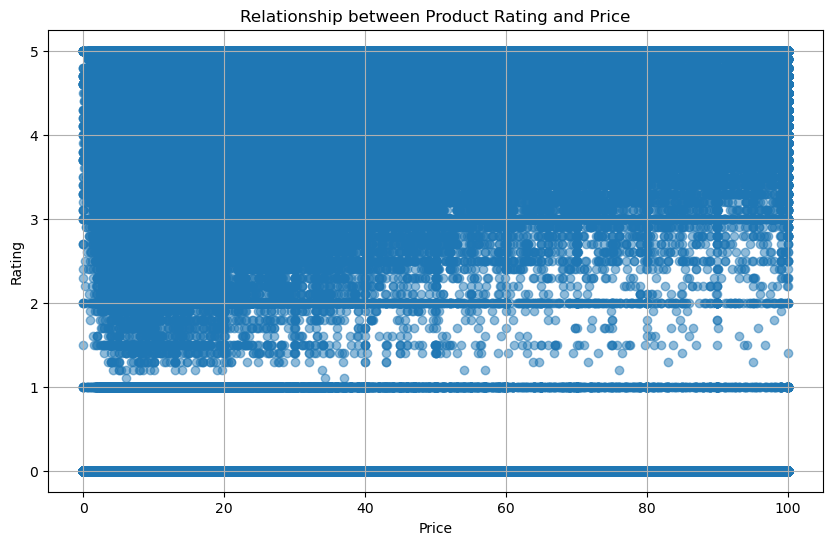

In [97]:
# Create a scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['price'], df_filtered['stars'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Relationship between Product Rating and Price')
plt.grid(True)
plt.show()

In [98]:
#? Use a correlation heatmap to visualize correlations between all numerical variables.

In [107]:
import seaborn as sns

# Select numerical columns for correlation analysis
numerical_columns = ['price', 'stars', 'reviews']

In [111]:
# Calculate correlation matrix

correlation_matrix = df_filtered[numerical_columns].corr()

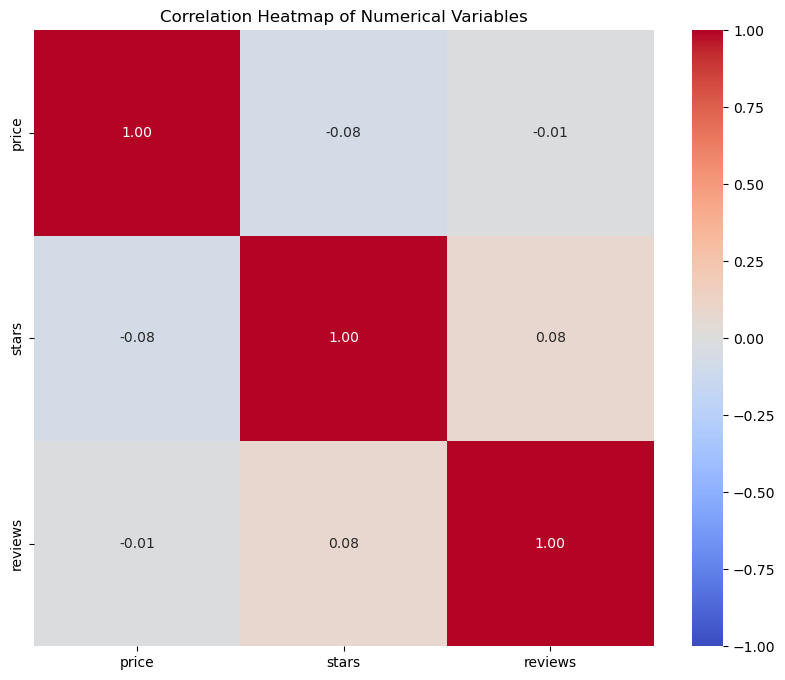

In [110]:
# Create a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()